# **Download and prepare assets**

In [1]:
import os, sys, shutil
from IPython.display import clear_output
!sudo apt update
!sudo apt upgrade
!sudo apt-get install git cmake build-essential libboost-program-options-dev libboost-filesystem-dev libboost-graph-dev \
    libboost-system-dev libboost-test-dev libeigen3-dev libsuitesparse-dev libfreeimage-dev libgoogle-glog-dev \
    libgflags-dev libglew-dev qtbase5-dev libqt5opengl5-dev libcgal-dev libatlas-base-dev libsuitesparse-dev glances
!pip3 install -q --upgrade --no-cache-dir gdown
!gdown 1ay-A1jPPIQFiWi_1X4Mw31Nfhqku2Gvd
!gdown 1F9peL5cQ7EhBxvNc8HMMmrzs92rOZjnu
!sudo dpkg -i '/content/Ceres_Solver_build_20220101-1_amd64.deb'
!sudo dpkg -i '/content/Colmap_build_20220101-1_amd64.deb'
os.chdir('/content')
if not os.path.isdir('/content/UAVPatches'):  
  !git clone -q https://github.com/farhadinima75/UAVPatches.git
os.chdir('/content/UAVPatches')
sys.path.append('/content/UAVPatches')

#Download HardNet and Brown6 descriptor weights
!wget -q -O ./Pretrained/HardNet.pth https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty/checkpoint_liberty_no_aug.pth
!wget -q -O ./Pretrained/Brown6.pth https://github.com/DagnyT/hardnet/raw/master/pretrained/6Brown/hardnetBr6.pth
#Install PySLAM
!git clone -q https://github.com/farhadinima75/pyslam.git

os.chdir('/content/UAVPatches/pyslam')
!apt update
!./install_basic.sh   #Approximately 5 min.

#Install requirements
os.chdir('/content/UAVPatches')
!pip3 install -q -U PyYAML
!pip3 install -q -r Requirements.txt
!pip3 install -q rasterio rio-color numpy==1.18.3 scipy==1.2.2 tensorboard==1.15
clear_output()
exit() #we must reset the runtime for configuring the new packages. exit() will do the job.

# **Matching 2 UAV images with UAVPatches+, UAVPatches, HardNet and SIFT**

Please select 2 images (left and right image).


Saving DJI_0010.JPG to DJI_0010.JPG
Saving DJI_0012.JPG to DJI_0012.JPG
Matching images with DISK_DISK...  num_levels:  1
using opencv  4.5.1
Using DiskFeature2D
cuda: True
==> Loading pre-trained network.
==> Successfully loaded pre-trained network.
 using same detector and descriptor object:  DISK
num_levels:  1
================= True 1 torch.Size([1, 3, 1216, 1632])
detector: DISK, descriptor: DISK, #features:  32835 , frame res:  (1228, 1638)
detector: DISK , #features: 32835 , [kp-filter: SAT ]
descriptor: DISK , #features: 32835 , [kp-filter: SAT ]
================= True 1 torch.Size([1, 3, 1216, 1632])
detector: DISK, descriptor: DISK, #features:  31985 , frame res:  (1228, 1638)
detector: DISK , #features: 31985 , [kp-filter: SAT ]
descriptor: DISK , #features: 31985 , [kp-filter: SAT ]
Final Matches: 1717
Detector and Descriptor Time: 1.54
Colmap SFM Failed. Normally, increasing MaxSumImgSize or TotalKeyPoints will solve the problem.
RANSAC 3pix: True -----[DISK_DISK]----- Mat

/root/.local/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


Extracting torch model on GPU
==> Successfully loaded pre-trained network.
 using same detector and descriptor object:  KEYNET
num_levels:  5
detector: KEYNET, descriptor: KEYNET, #features:  28131 , frame res:  (1228, 1638)
detector: KEYNET , #features: 28131 , [kp-filter: NONE ]
detector: KEYNET, descriptor: KEYNET, #features:  28131 , frame res:  (1228, 1638)
descriptor: KEYNET , #features: 28131 , [kp-filter: NONE ]
detector: KEYNET, descriptor: KEYNET, #features:  27970 , frame res:  (1228, 1638)
detector: KEYNET , #features: 27970 , [kp-filter: NONE ]
detector: KEYNET, descriptor: KEYNET, #features:  27970 , frame res:  (1228, 1638)
descriptor: KEYNET , #features: 27970 , [kp-filter: NONE ]
Final Matches: 1945
Detector and Descriptor Time: 40.57
Colmap SFM Failed. Normally, increasing MaxSumImgSize or TotalKeyPoints will solve the problem.
RANSAC 3pix: True -----[KEYNET_KEYNET]----- Matches: 1945 -- Matches below 0.6: 1362
KEYNET: closing tf session
Done. ________________________

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


detector: SUPERPOINT, #features:  1236 , frame res:  (1228, 1638)
detector: SUPERPOINT , #features: 1236 , [kp-filter: SAT ]
detector: SUPERPOINT, #features:  1236 , frame res:  (1228, 1638)
descriptor: SUPERPOINT , #features: 1236 , [kp-filter: SAT ]
detector: SUPERPOINT, #features:  1335 , frame res:  (1228, 1638)
detector: SUPERPOINT , #features: 1335 , [kp-filter: SAT ]
detector: SUPERPOINT, #features:  1335 , frame res:  (1228, 1638)
descriptor: SUPERPOINT , #features: 1335 , [kp-filter: SAT ]
Final Matches: 40
Detector and Descriptor Time: 0.93
Colmap SFM Points: 39
Colmap SFM Mean reprojection error: 1.017331px
Colmap SFM (Below 0.25 pix Error) Points: 6
Colmap SFM (Below 0.25 pix Error) Mean reprojection error: 0.091627px
RANSAC 3pix: True -----[SUPERPOINT_SUPERPOINT]----- Matches: 40 -- Matches below 0.6: 28
Done. ____________________________________________________________
Matching images with AKAZE_AKAZE...  num_levels:  8
using opencv  4.5.1
 forcing scale factor=2 for dete

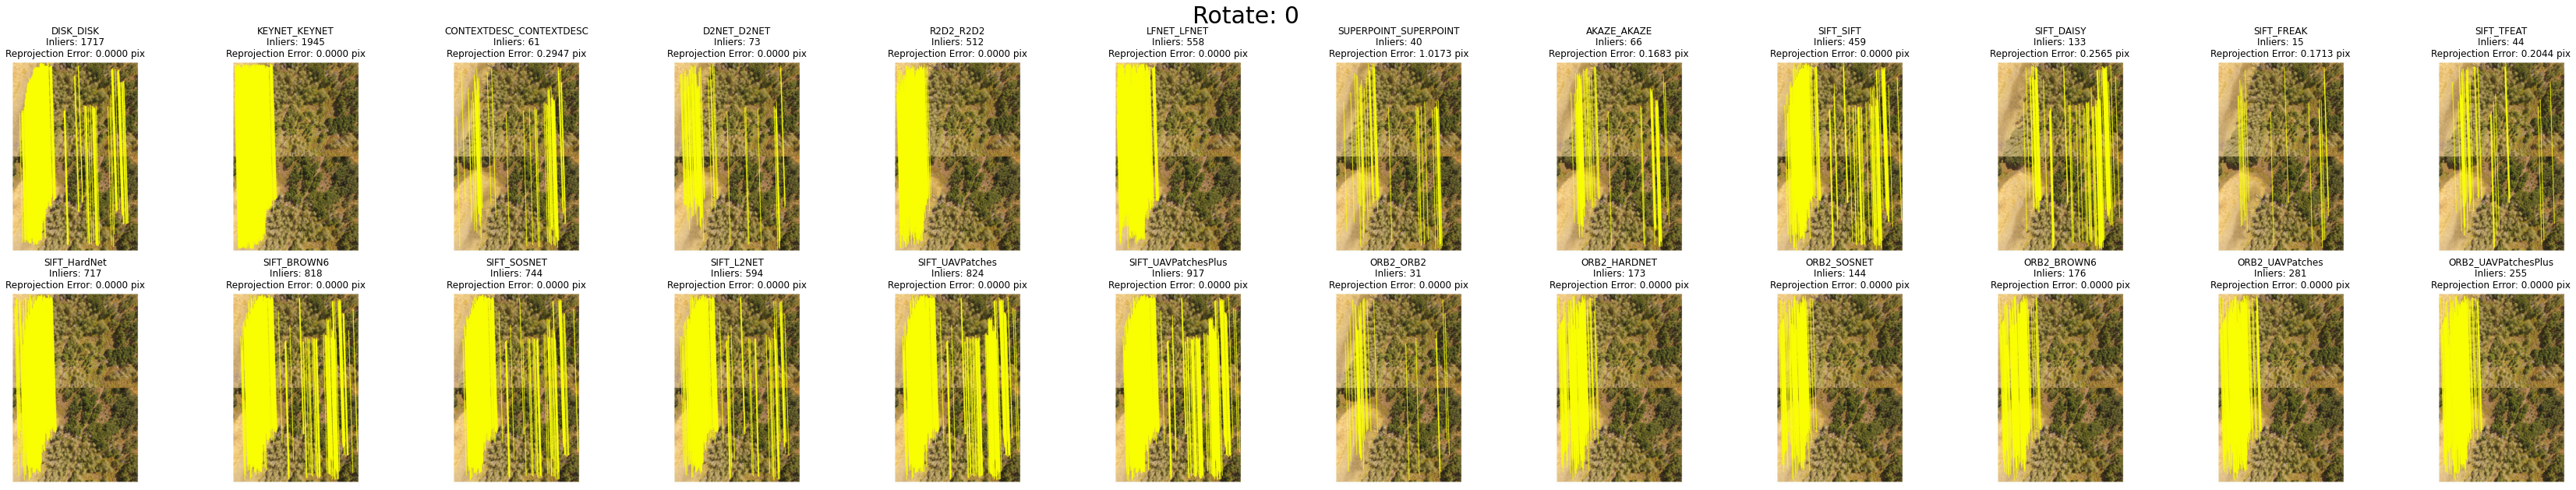

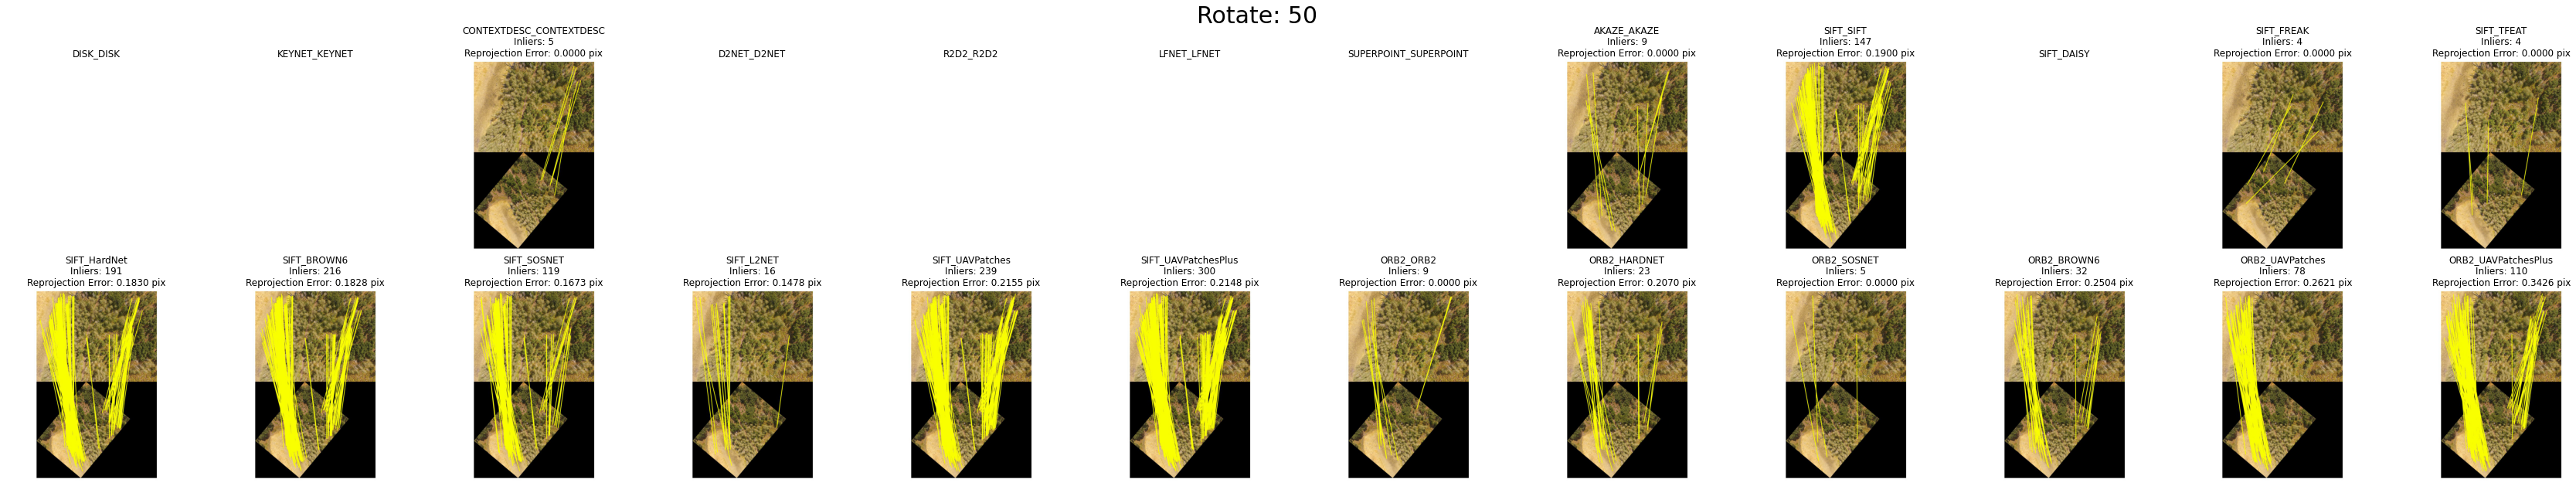

In [1]:
import os, sys, torch, cv2, time, gc, shutil, numpy as np, glob, tensorflow as tf
torch.set_num_threads(2) 
os.chdir('/content/UAVPatches')
sys.path.append('/content/UAVPatches')
sys.path.append('/content/UAVPatches/pyslam')
from Utils.Matching import *
from Utils.Model import HardNet
from Utils.Visualize import draw_matches
from google.colab import files
from matplotlib import pyplot as plt
from IPython.display import clear_output

def UploadImages():
  print('Please select 2 images (left and right image).')
  Images = '/content/UAVPatches/Images'
  os.makedirs(Images, exist_ok=True)
  os.chdir(Images)
  uploaded = files.upload()
  os.chdir(Images.replace('Images', ''))
  return os.path.join(Images, list(uploaded.keys())[0]), os.path.join(Images, list(uploaded.keys())[1])

def Match2Image(DescName, img1, img2, Rotate=0):
  if   DescName == 'SIFT_UAVPatchesPlus':       DetDesc = SIFT_UAVPatchesPlus(TotalKeyPoints)
  elif DescName == 'SIFT_UAVPatches':           DetDesc = SIFT_UAVPatches(TotalKeyPoints)
  elif DescName == 'SIFT_MKDDescriptor':        DetDesc = SIFT_MKDDescriptor(TotalKeyPoints)
  elif DescName == 'SIFT_HyNet':                DetDesc = SIFT_HyNet(TotalKeyPoints)
  elif DescName == 'SIFT_HardNet':              DetDesc = SIFT_HARDNET(TotalKeyPoints)
  elif DescName == 'SIFT_BROWN6':               DetDesc = SIFT_BROWN6(TotalKeyPoints)
  elif DescName == 'R2D2_R2D2':                 DetDesc = R2D2_R2D2(TotalKeyPoints)
  elif DescName == 'D2NET_D2NET':               DetDesc = D2NET_D2NET(TotalKeyPoints)
  elif DescName == 'SIFT_GEODESC':              DetDesc = SIFT_GEODESC(TotalKeyPoints)
  elif DescName == 'SIFT_SOSNET':               DetDesc = SIFT_SOSNET(TotalKeyPoints)
  elif DescName == 'SIFT_L2NET':                DetDesc = SIFT_L2NET(TotalKeyPoints)
  elif DescName == 'SIFT_ROOT_SIFT':            DetDesc = SIFT_ROOT_SIFT(TotalKeyPoints)
  elif DescName == 'SIFT_TFEAT':                DetDesc = SIFT_TFEAT(TotalKeyPoints)
  elif DescName == 'CONTEXTDESC_CONTEXTDESC':   DetDesc = CONTEXTDESC_CONTEXTDESC(TotalKeyPoints)
  elif DescName == 'KEYNET_KEYNET':             DetDesc = KEYNET_KEYNET(TotalKeyPoints)
  elif DescName == 'ORB2_ORB2':                 DetDesc = ORB2_ORB2(TotalKeyPoints)
  elif DescName == 'AKAZE_AKAZE':               DetDesc = AKAZE_AKAZE(TotalKeyPoints)
  elif DescName == 'SUPERPOINT_SUPERPOINT':     DetDesc = SUPERPOINT_SUPERPOINT(TotalKeyPoints)
  elif DescName == 'LFNET_LFNET':               DetDesc = LFNET_LFNET(TotalKeyPoints)
  elif DescName == 'DELF_DELF':                 DetDesc = DELF_DELF(TotalKeyPoints)
  elif DescName == 'DISK_DISK':                 DetDesc = DISK_DISK(TotalKeyPoints)
  elif DescName == 'MSER_HARDNET':              DetDesc = MSER_HARDNET(TotalKeyPoints)
  elif DescName == 'SIFT_VGG':                  DetDesc = SIFT_VGG(TotalKeyPoints)
  elif DescName == 'SIFT_DAISY':                DetDesc = SIFT_DAISY(TotalKeyPoints)
  elif DescName == 'SIFT_BOOST_DESC':           DetDesc = SIFT_BOOST_DESC(TotalKeyPoints)
  elif DescName == 'SIFT_LATCH':                DetDesc = SIFT_LATCH(TotalKeyPoints)
  elif DescName == 'SIFT_FREAK':                DetDesc = SIFT_FREAK(TotalKeyPoints)
  elif DescName == 'ORB2_UAVPatchesPlus':       DetDesc = ORB2_UAVPatchesPlus(TotalKeyPoints)
  elif DescName == 'ORB2_UAVPatches':           DetDesc = ORB2_UAVPatches(TotalKeyPoints)
  elif DescName == 'ORB2_MKDDescriptor':        DetDesc = ORB2_MKDDescriptor(TotalKeyPoints)
  elif DescName == 'ORB2_HyNet':                DetDesc = ORB2_HyNet(TotalKeyPoints)
  elif DescName == 'ORB2_HARDNET':              DetDesc = ORB2_HARDNET(TotalKeyPoints)
  elif DescName == 'ORB2_BROWN6':               DetDesc = ORB2_BROWN6(TotalKeyPoints)
  elif DescName == 'ORB2_SOSNET':               DetDesc = ORB2_SOSNET(TotalKeyPoints)
  elif DescName == 'SIFT_SIFT':                 DetDesc = SIFT_SIFT(TotalKeyPoints)

  MatchInit = TwoViewMatcher(detector_descriptor=DetDesc,
                            matcher=SNNMMatcher(SNN_Tr), geom_verif=degensac_Verifier(DEGENSAC_Tr))
  MatchOut = MatchInit.verify(img1, img2, Rotate=Rotate, MaxSumImgSize=MaxSumImgSize)
  draw_matches(MatchOut['match_kpts1'], MatchOut['match_kpts2'],
              MatchOut['img1'], MatchOut['img2'], path=os.path.join(OutputDir, DescName), figsize=(6,11), color=(250,255,0), vert=True, R=6)

  plt.figure()
  A = plt.hist(MatchOut['dists'], bins=50, range=(0,1))
  plt.close()
  with open(os.path.join(OutputDir, f"_{img1.split('/')[3]}.txt"), 'a') as File:
    print('RANSAC 3pix: True -----[%s]----- Matches: %d -- Matches below 0.6: %d'%(DescName, len(MatchOut['match_kpts1']), int(A[0][:int(np.where(A[1]==0.6)[0]+1)].sum())))
  return MatchOut['SFMReprojectionError'], MatchOut['num_inl']
  
'''
#########################################################
################ Main ###################################
#########################################################
'''

TotalKeyPoints = 40000
MaxSumImgSize = 3000
SNN_Tr = 0.7        
DEGENSAC_Tr = 10.0   
Rotations = [0, 50] # Degree
Detector_Descriptor = ['DISK_DISK', 'KEYNET_KEYNET', 'CONTEXTDESC_CONTEXTDESC', 'D2NET_D2NET', 'R2D2_R2D2', 'LFNET_LFNET', 'SUPERPOINT_SUPERPOINT', 'AKAZE_AKAZE', 'SIFT_SIFT', 
                       'SIFT_DAISY', 'SIFT_FREAK', 'SIFT_TFEAT', 'SIFT_HardNet', 'SIFT_BROWN6', 'SIFT_SOSNET', 'SIFT_L2NET', 'SIFT_UAVPatches', 
                       'SIFT_UAVPatchesPlus', 'ORB2_ORB2', 'ORB2_HARDNET', 'ORB2_SOSNET', 'ORB2_BROWN6', 'ORB2_UAVPatches', 'ORB2_UAVPatchesPlus']

OutputDir = '/content/UAVPatches/Outputs'
if os.path.isdir(OutputDir): shutil.rmtree(OutputDir)
os.makedirs(OutputDir, exist_ok=True)

def main():
  clear_output()
  img1, img2 = UploadImages()
  for Rotate in Rotations:
    Fig, Axs = plt.subplots(2, len(Detector_Descriptor)//2, figsize=(60,10))
    R, C = 0, 0
    for i, DName in enumerate(Detector_Descriptor):
      for D in sorted(glob.glob(OutputDir.replace('Outputs', 'Images/*'))): 
        if D.endswith(('.db', '.txt', 'shm', 'wal')): os.remove(D)
      if i == len(Detector_Descriptor)//2: R+=1; C=0
      gc.collect() 
      if len(Detector_Descriptor) == 1: Axs.set_title(f"{DName}"); Axs.axis('off')
      else: Axs[R,C].set_title(f"{DName}"); Axs[R,C].axis('off')
      if torch.cuda.is_available(): torch.cuda.empty_cache(); torch.cuda.ipc_collect(); tf.reset_default_graph()
      print('Matching images with {}...  '.format(DName), end='')
      try:
        ReprojectionError, Inliers = Match2Image(DName, img1, img2, Rotate=Rotate)
        if len(Detector_Descriptor) == 1: Axs.imshow(plt.imread(os.path.join(OutputDir, DName) + '.JPG')); Axs.set_title(f"{DName}\nInliers: {Inliers}\nReprojection Error: {ReprojectionError:.4f} pix"); Axs.axis('off')
        else: Axs[R,C].imshow(plt.imread(os.path.join(OutputDir, DName) + '.JPG')); Axs[R,C].set_title(f"{DName}\nInliers: {Inliers}\nReprojection Error: {ReprojectionError:.4f} pix"); Axs[R,C].axis('off')
      except Exception as E: print(f'\033[91mWe cant find enough matches.\033[0m', E.args); ReprojectionError = 0.0
      print('Done.', '_'*60)
      C+=1
    Fig.savefig(os.path.join(OutputDir, f'OutAll_Rot{Rotate}.jpg'), dpi=150, bbox_inches='tight')
    Fig.suptitle(f'Rotate: {Rotate}', fontsize=30)
    for D in sorted(glob.glob(OutputDir.replace('Outputs', 'Images/*'))): 
      if D.endswith(('.db', '.txt', 'shm', 'wal')): os.remove(D)
  print(f'\033[1m\033[96mClick on output for increasing magnification.\033[0m')

if __name__ == '__main__':
  main()